# CLASSIFICATION PROJECT - Predicting Customer Churn

Classification in machine learning and statistics is a supervised learning approach in which the computer program learns from the data given to it and makes new observations or classifications. The main goal is to identify which class/category the new data will fall into. 


## Objective of Project
1. Learn more about classification models and help the client, a telecommunication company, to understand their data.
2. Find the lifetime value of each customer.
know what factors affect the rate at which customers stop using their network.
3. Predict if a customer will churn or not

## Goal
To analyse customer churn rate and build classification models to perform churn analysis on a telecommunication company's customers



## Data
The datasets where extracted from three(3) places. 

* First dataset - First 3000 records of the dataset was extracted from Microsoft SQL Server
* Second dataset - The second 2000 records of the dataset was downloaded from OneDrive
* Third dataset - The third part of the data was downloaded from a GitHub Repository

## Hypothesis
* H_o: Contract type does not influence customer Churn
* H_a: Contract type influences customer Churn

## Research Questions

1. How does gender impact customer churn? Are there significant differences in churn rates between male and female customers?

2. Does the presence of a partner or dependents influence customer churn? Is there a relationship between marital status and churn behavior?

3. How does the length of tenure affect churn rates? Are customers with longer tenures less likely to churn compared to new customers?


4. What role do additional services (e.g., online security, tech support, streaming TV, etc.) play in reducing customer churn? Are customers with more services less likely to churn?

5. Is there a correlation between the contract term (month-to-month, one year, two years) and churn rates? Are customers on long-term contracts less likely to churn compared to those on month-to-month contracts?

In [1]:
#%pip install pyodbc  
#%pip install python-dotenv

#install openpyxl to overcome Import error of .xlsx file(Telco-churn-second-2000.xlsx)
#%pip install openpyxl
#%pip install -qU scikit-learn pandas-profiling
#%pip install ydata-profiling
#%pip install imbalanced-learn

In [238]:
# import libraries to use

import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from scipy.stats import pointbiserialr
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Machine Learning 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')

import pickle
import os


In [4]:
# credentials for data extraction from Microsoft server

environment_variables=dotenv_values('.env')

database=environment_variables.get("DATABASE")
server=environment_variables.get("SERVER")
username=environment_variables.get("USERNAME")
password=environment_variables.get("PASSWORD")

connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [5]:
connection=pyodbc.connect(connection_string)

In [6]:
# extract first 3000 and name data1
# preview first 5 data with .head()

query="Select * from dbo.LP2_Telco_churn_first_3000"
data1=pd.read_sql(query, connection)

data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [7]:
# Save extracted data as data1.csv

data1.to_csv('data1.csv')

In [8]:
#import second dataset and name as data2
#store as data2.csv
#preview first five data with .head()

data2 = pd.read_csv(r"C:\Users\lenovo\Desktop\Seth\Personal\Azubi\Career Accelarator prog\LP2\LP2_Telco-churn-last-2000.csv")
data2.to_csv('data2.csv')

#get information on data2

data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


## Data Preprocessing
* In the data preprocessing phase, we check the columns, shape, and information on the data to understand its dimensions. 
* We then check for null values in the dataset and impute or remove them depending on the circumstances
* Also we perform a check for duplicate values and replace them to ensure data integrity


In [9]:
# check column names of data1
data1.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [10]:
#get information on data1 - column names, non-null values, number of entries, number of columns, and datatype

data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [11]:
# Checking the null values in the dataset
# percentage of missing values in data1

data1.isna().sum()/len(data1)*100

customerID           0.000000
gender               0.000000
SeniorCitizen        0.000000
Partner              0.000000
Dependents           0.000000
tenure               0.000000
PhoneService         0.000000
MultipleLines        8.966667
InternetService      0.000000
OnlineSecurity      21.700000
OnlineBackup        21.700000
DeviceProtection    21.700000
TechSupport         21.700000
StreamingTV         21.700000
StreamingMovies     21.700000
Contract             0.000000
PaperlessBilling     0.000000
PaymentMethod        0.000000
MonthlyCharges       0.000000
TotalCharges         0.166667
Churn                0.033333
dtype: float64

In [12]:
#Checking the data shape

print(f'The first 3000 dataset contains {data1.shape[0]} rows and {data1.shape[1]} columns')

The first 3000 dataset contains 3000 rows and 21 columns


In [13]:
#check column names of data2

data2.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [14]:
#get information on data2 - column names, non-null values, number of entries, number of columns, and datatype

data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [15]:
# Check the percentage of null values in the data2

data2.isna().sum()/len(data1)*100

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [16]:
#Check the data shape

print(f'The next dataset contains {data2.shape[0]} rows and {data2.shape[1]} columns')

The next dataset contains 2043 rows and 21 columns


In [17]:
# Compare the two DataFrames data1 and data2 side-by-side
# The idea is to easily compare so we can clean dataset before we merge as a train dataset

# Create custom summary DataFrames for each DataFrame
summary_data1 = pd.DataFrame({'Column Name': data1.columns, 'Data Type': data1.dtypes, 'Non-Null Count': data1.count()})
summary_data2 = pd.DataFrame({'Column Name': data2.columns, 'Data Type': data2.dtypes, 'Non-Null Count': data2.count()})

# Set 'Column Name' as the index for both summary DataFrames
summary_data1.set_index('Column Name', inplace=True)
summary_data2.set_index('Column Name', inplace=True)

# Concatenate the two summary DataFrames side by side
comparison = pd.concat([summary_data1, summary_data2], axis=1, keys=['DataFrame 1', 'DataFrame 2'])

# Print the side-by-side comparison
print(comparison)

                 DataFrame 1                DataFrame 2               
                   Data Type Non-Null Count   Data Type Non-Null Count
Column Name                                                           
customerID            object           3000      object           2043
gender                object           3000      object           2043
SeniorCitizen           bool           3000       int64           2043
Partner                 bool           3000      object           2043
Dependents              bool           3000      object           2043
tenure                 int64           3000       int64           2043
PhoneService            bool           3000      object           2043
MultipleLines         object           2731      object           2043
InternetService       object           3000      object           2043
OnlineSecurity        object           2349      object           2043
OnlineBackup          object           2349      object           2043
Device

From the above the following was observed:
* Both have the same column names
* There are different datatypes in some columns. For instance SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling, and TotalCharges
* Data cleaning will be done side by side before merging. 
* We will refer from the readme instructions for proper datatype


## Clean columns
## customerID
Check and clean columns step by step

In [18]:
#Preview data1 'customerID column

data1['customerID'].head()

0    7590-VHVEG
1    5575-GNVDE
2    3668-QPYBK
3    7795-CFOCW
4    9237-HQITU
Name: customerID, dtype: object

In [19]:
#Preview data2 'customerID column

data2['customerID'].head()

0    5600-PDUJF
1    8292-TYSPY
2    0567-XRHCU
3    1867-BDVFH
4    2067-QYTCF
Name: customerID, dtype: object

## gender


In [20]:
#preview gender column in data1

data1['gender'].head()

0    Female
1      Male
2      Male
3      Male
4    Female
Name: gender, dtype: object

In [21]:
#check unique characters in gender column in data1

data1['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [22]:
#preview gender column in data2

data2['gender'].head()

0      Male
1      Male
2    Female
3      Male
4    Female
Name: gender, dtype: object

In [23]:
#check unique characters in gender column in data2

data2['gender'].unique()

array(['Male', 'Female'], dtype=object)

The 'gender' column for both data looks clean. 


## SeniorCitizen

From Data Understanding document:
* SeniorCitizen -- Whether a customer is a senior citizen or not

There are no missing data but the datatype is different. data1 is a boolean while data2 is made up of integers


In [24]:
data1['SeniorCitizen'].unique()

array([False,  True])

In [25]:
data2['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [26]:
# Convert the binary column to boolean datatype
data2['SeniorCitizen'] = data2['SeniorCitizen'].astype(bool)

In [27]:
data2['SeniorCitizen'].unique()

array([False,  True])

## Partner

Convert data2['Partner'] to boolean datatype to reflect Data understanding documentation

* Whether the customer has a partner or not (Yes, No)

In [28]:
data2['Partner'].head()

0     No
1     No
2    Yes
3    Yes
4    Yes
Name: Partner, dtype: object

In [29]:
data1['Partner'].head()

0     True
1    False
2    False
3    False
4    False
Name: Partner, dtype: bool

In [30]:
data2['Partner'].unique()

array(['No', 'Yes'], dtype=object)

In [31]:
#Replace 'Yes' or 'No' with True or False

data2['Partner'].replace('Yes', True, inplace=True)
data2['Partner'].replace('No', False, inplace=True)
data2['Partner'].head()

0    False
1    False
2     True
3     True
4     True
Name: Partner, dtype: bool

## Dependent 
Convert to reflect readme documentation on data understanding
* Dependents -- Whether the customer has dependents or not (Yes, No)

In [32]:
data1['Dependents'].head()

0    False
1    False
2    False
3    False
4    False
Name: Dependents, dtype: bool

In [33]:
data1['Dependents'].unique()

array([False,  True])

In [34]:
data2['Dependents'].head()

0     No
1     No
2    Yes
3    Yes
4     No
Name: Dependents, dtype: object

In [35]:
#Replace 'Yes' or 'No' with True or False

data2['Dependents'].replace('Yes', True, inplace=True)
data2['Dependents'].replace('No', False, inplace=True)
data2['Dependents'].head()

0    False
1    False
2     True
3     True
4    False
Name: Dependents, dtype: bool

## tenure



In [36]:
data1['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

In [37]:
data2['tenure'].unique()

array([ 6, 19, 69, 11, 64, 39, 15, 25, 66, 61, 43, 12, 23, 71, 34,  5, 41,
       72, 14,  1, 10,  7,  9, 48, 20, 16,  2, 22, 35, 54, 56, 18, 68, 53,
       30, 36, 55, 21, 33, 44,  4, 49, 42, 67, 40, 45, 57,  8, 65,  3, 17,
       28, 52, 47, 50, 46, 29, 27, 13, 24, 62, 26, 60, 51, 70, 59, 38, 37,
        0, 58, 31, 32, 63], dtype=int64)

In [38]:
data1['tenure'].isnull().sum()

0

In [39]:
data2['tenure'].isnull().sum()

0

## PhoneService

Convert to reflect readme documentation on data understanding

* Phone Service -- Whether the customer has a phone service or not (Yes, No)

In [40]:
data1['PhoneService'].head()

0    False
1     True
2     True
3    False
4     True
Name: PhoneService, dtype: bool

In [41]:
data2['PhoneService'].head()

0    Yes
1    Yes
2     No
3    Yes
4    Yes
Name: PhoneService, dtype: object

In [42]:
#Replace 'Yes' or 'No' with True or False

data2['PhoneService'].replace('Yes', True, inplace=True)
data2['PhoneService'].replace('No', False, inplace=True)
data2['PhoneService'].head()

0     True
1     True
2    False
3     True
4     True
Name: PhoneService, dtype: bool

## MultipleLines

data1 has some missing values about 8.9%
impute with mode

In [43]:
#confirm number of missing values

data1['MultipleLines'].isnull().sum()

269

In [44]:
data1['MultipleLines'].unique()

array([None, False, True], dtype=object)

In [45]:
data1['MultipleLines'].value_counts()

MultipleLines
False    1437
True     1294
Name: count, dtype: int64

In [46]:
#impute missing values with mode
mode_multiplelines = data1['MultipleLines'].mode()[0]

data1['MultipleLines'].fillna(mode_multiplelines, inplace=True)
data1['MultipleLines'].isnull().sum()


0

In [47]:
data1['MultipleLines'].value_counts()

MultipleLines
False    1706
True     1294
Name: count, dtype: int64

In [48]:
data2['MultipleLines'].unique()

array(['No', 'No phone service', 'Yes'], dtype=object)

In [49]:
data2['MultipleLines'].head()

0                  No
1                  No
2    No phone service
3                 Yes
4                 Yes
Name: MultipleLines, dtype: object

In [50]:
data2['MultipleLines'].value_counts()

MultipleLines
No                  987
Yes                 836
No phone service    220
Name: count, dtype: int64

In [51]:
#we assume that an answer of 'No phone service' is the same as No, since a customer without phone service will have no need for multiplelines

# Replace 'No phone service' with 'No' in the 'MultipleLines' column
data2['MultipleLines'].replace('No phone service', 'No', inplace=True)
data2['MultipleLines'].value_counts()

MultipleLines
No     1207
Yes     836
Name: count, dtype: int64

In [52]:
#confirm number of missing values

data2['MultipleLines'].isnull().sum()

0

In [53]:
data2['MultipleLines'].value_counts()

MultipleLines
No     1207
Yes     836
Name: count, dtype: int64

In [54]:
data2['MultipleLines'].replace('Yes', True, inplace=True)
data2['MultipleLines'].replace('No', False, inplace=True)
data2['MultipleLines'].head()

0    False
1    False
2    False
3     True
4     True
Name: MultipleLines, dtype: bool

In [55]:
data2['MultipleLines'].value_counts()

MultipleLines
False    1207
True      836
Name: count, dtype: int64

In [56]:
data2['MultipleLines'].unique()

array([False,  True])

In [57]:
data1['MultipleLines'].unique()

array([False,  True])

## InternetService

In [58]:
data1['InternetService'].isnull().sum()

0

In [59]:
data1['InternetService'].nunique()

3

In [60]:
data1['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [61]:
data2['InternetService'].nunique()

3

In [62]:
data1['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

'InternetService' column is clean


## OnlineSecurity

* OnlineSecurity -- Whether the customer has online security or not (Yes, No, No Internet)

In [63]:
data1['OnlineSecurity'].unique()

array([False, True, None], dtype=object)

In [64]:
data1['OnlineSecurity'].value_counts()

OnlineSecurity
False    1478
True      871
Name: count, dtype: int64

In [65]:
data1['OnlineSecurity'].isnull().sum()

651

In [66]:
# We assume the missing data is a response to the third option 'No Internet'. Hence will fill missing with 'No Internet'
# Impute missing values with 'No Internet'.


data1['OnlineSecurity'].fillna('No Internet', inplace=True)
data1['OnlineSecurity'].value_counts()

OnlineSecurity
False          1478
True            871
No Internet     651
Name: count, dtype: int64

In [67]:
data2['OnlineSecurity'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [68]:
data2['OnlineSecurity'].value_counts()

OnlineSecurity
No                     1029
Yes                     585
No internet service     429
Name: count, dtype: int64

In [69]:
# Replace 'No internet service' with 'No Internet' in the 'MultipleLines' column
data2['OnlineSecurity'].replace('No internet service', 'No Internet', inplace=True)
data2['OnlineSecurity'].value_counts()

OnlineSecurity
No             1029
Yes             585
No Internet     429
Name: count, dtype: int64

## OnlineBackup

* OnlineBackup -- Whether the customer has online backup or not (Yes, No, No Internet)

In [70]:
data1['OnlineBackup'].isnull().sum()

651

In [71]:
data1['OnlineBackup'].unique()

array([True, False, None], dtype=object)

In [72]:
data2['OnlineBackup'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [73]:
# Replace 'False' with 'No' and 'True' with 'Yes' the 'OnlineBackup' column
# Fill missing values with 'No Internet'

data1['OnlineBackup'].replace(True, 'Yes', inplace=True)
data1['OnlineBackup'].replace(False, 'No', inplace=True)

data1['OnlineBackup'].fillna('No Internet', inplace=True)
data1['OnlineBackup'].value_counts()


OnlineBackup
No             1320
Yes            1029
No Internet     651
Name: count, dtype: int64

In [74]:
# Replace 'No internet service' with 'No Internet'

data2['OnlineBackup'].replace('No internet service', 'No Internet', inplace=True)
data2['OnlineBackup'].unique()

array(['No', 'Yes', 'No Internet'], dtype=object)

## DeviceProtection

* DeviceProtection -- Whether the customer has device protection or not (Yes, No, No internet service)

In [75]:
data1['DeviceProtection'].unique()

array([False, True, None], dtype=object)

In [76]:
data1['DeviceProtection'].isnull().sum()

651

In [77]:
# Replace 'False' with 'No' and 'True' with 'Yes' the 'OnlineBackup' column
# Fill missing values with 'No Internet'

data1['DeviceProtection'].replace(True, 'Yes', inplace=True)
data1['DeviceProtection'].replace(False, 'No', inplace=True)

data1['DeviceProtection'].fillna('No internet service', inplace=True)
data1['DeviceProtection'].value_counts()

DeviceProtection
No                     1296
Yes                    1053
No internet service     651
Name: count, dtype: int64

In [78]:
data2['DeviceProtection'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

## TechSupport

* TechSupport -- Whether the customer has tech support or not (Yes, No, No internet)

In [79]:
data1['TechSupport'].unique()

array([False, True, None], dtype=object)

In [80]:
data1['TechSupport'].replace(True, 'Yes', inplace=True)
data1['TechSupport'].replace(False, 'No', inplace=True)

data1['TechSupport'].fillna('No internet', inplace=True)
data1['TechSupport'].value_counts()

TechSupport
No             1476
Yes             873
No internet     651
Name: count, dtype: int64

In [81]:
data1['TechSupport'].isnull().sum()

0

In [82]:
data2['TechSupport'].unique()

array(['Yes', 'No', 'No internet service'], dtype=object)

In [83]:
data2['TechSupport'].replace('No internet service', 'No internet', inplace=True)
data2['TechSupport'].unique()

array(['Yes', 'No', 'No internet'], dtype=object)

## StreamingTV

* StreamingTV -- Whether the customer has streaming TV or not (Yes, No, No internet service)

In [84]:
data1['StreamingTV'].unique()

array([False, True, None], dtype=object)

In [85]:
data1['StreamingTV'].replace(True, 'Yes', inplace=True)
data1['StreamingTV'].replace(False, 'No', inplace=True)

data1['StreamingTV'].fillna('No internet service', inplace=True)
data1['StreamingTV'].value_counts()

StreamingTV
No                     1190
Yes                    1159
No internet service     651
Name: count, dtype: int64

In [86]:
data2['StreamingTV'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

## StreamingMovies

* StreamingMovies -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

In [87]:
data1['StreamingMovies'].unique()

array([False, True, None], dtype=object)

In [88]:
data1['StreamingMovies'].replace(True, 'Yes', inplace=True)
data1['StreamingMovies'].replace(False, 'No', inplace=True)

data1['StreamingMovies'].fillna('No internet service', inplace=True)
data1['StreamingMovies'].value_counts()

StreamingMovies
Yes                    1199
No                     1150
No internet service     651
Name: count, dtype: int64

In [89]:
data2['StreamingMovies'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

## Contract


In [90]:
data1['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [91]:
data2['Contract'].unique()

array(['Month-to-month', 'Two year', 'One year'], dtype=object)

## PaperlessBilling

* PaperlessBilling -- Whether the customer has paperless billing or not (Yes, No)

In [92]:
data1['PaperlessBilling'].unique()

array([ True, False])

In [93]:
data1['PaperlessBilling'].replace(True, 'Yes', inplace=True)
data1['PaperlessBilling'].replace(False, 'No', inplace=True)
data1['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [94]:
data2['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

## PaymentMethod



In [95]:
data1['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [96]:
data2['PaymentMethod'].unique()

array(['Credit card (automatic)', 'Electronic check', 'Mailed check',
       'Bank transfer (automatic)'], dtype=object)

## MonthlyCharges


In [97]:
data1['MonthlyCharges'].head()

0    29.850000
1    56.950001
2    53.849998
3    42.299999
4    70.699997
Name: MonthlyCharges, dtype: float64

In [98]:
#convert to 2 decimal places

data1['MonthlyCharges'] = data1['MonthlyCharges'].round(2)
data1['MonthlyCharges'].head()

0    29.85
1    56.95
2    53.85
3    42.30
4    70.70
Name: MonthlyCharges, dtype: float64

In [99]:
data2['MonthlyCharges'].head()

0     49.50
1     55.00
2     43.95
3     74.35
4    111.15
Name: MonthlyCharges, dtype: float64

## TotalCharges


In [100]:
data1['TotalCharges'].head()

0      29.850000
1    1889.500000
2     108.150002
3    1840.750000
4     151.649994
Name: TotalCharges, dtype: float64

In [101]:
data1['TotalCharges'] = data1['TotalCharges'].round(2)
data1['TotalCharges'].head()

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: float64

In [102]:
data1['TotalCharges'].isnull().sum()

5

In [103]:
# Drop rows with any missing values in the TotalCharges column
data1.dropna(subset='TotalCharges', inplace=True)
data1['TotalCharges'].isnull().sum()

0

In [104]:
data1['TotalCharges'].head()

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: float64

In [105]:
data2['TotalCharges'].head()

0     312.7
1    1046.5
2    2960.1
3     834.2
4    6953.4
Name: TotalCharges, dtype: object

In [106]:
# Convert the TotalCharges column to float datatype
data2['TotalCharges'] = pd.to_numeric(data2['TotalCharges'], errors='coerce').astype(float)

# Round the values to 2 decimal places
data2['TotalCharges'] = data2['TotalCharges'].round(2)
data2['TotalCharges'].head()


0     312.7
1    1046.5
2    2960.1
3     834.2
4    6953.4
Name: TotalCharges, dtype: float64

## Churn

In [107]:
data1['Churn'].isnull().sum()

1

In [108]:
data1['Churn'].unique()

array([False, True, None], dtype=object)

In [109]:
# Drop rows with any missing values in the Churn column
data1.dropna(subset='Churn', inplace=True)
data1['Churn'].isnull().sum()

0

In [110]:
data1['Churn'].unique()

array([False, True], dtype=object)

In [111]:
data1['Churn'].replace(True, 'Yes', inplace=True)
data1['Churn'].replace(False, 'No', inplace=True)
data1['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [112]:
data2['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [113]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   bool   
 3   Partner           2043 non-null   bool   
 4   Dependents        2043 non-null   bool   
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   bool   
 7   MultipleLines     2043 non-null   bool   
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [114]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2994 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2994 non-null   object 
 1   gender            2994 non-null   object 
 2   SeniorCitizen     2994 non-null   bool   
 3   Partner           2994 non-null   bool   
 4   Dependents        2994 non-null   bool   
 5   tenure            2994 non-null   int64  
 6   PhoneService      2994 non-null   bool   
 7   MultipleLines     2994 non-null   bool   
 8   InternetService   2994 non-null   object 
 9   OnlineSecurity    2994 non-null   object 
 10  OnlineBackup      2994 non-null   object 
 11  DeviceProtection  2994 non-null   object 
 12  TechSupport       2994 non-null   object 
 13  StreamingTV       2994 non-null   object 
 14  StreamingMovies   2994 non-null   object 
 15  Contract          2994 non-null   object 
 16  PaperlessBilling  2994 non-null   object 
 17  

In [115]:
data1.to_csv('clean_data1.csv', index=False)
data2.to_csv('clean_data2.csv', index=False)

In [116]:
#combine data1 and data2 since they are the train dataset
#covert to csv file and store as 'train.csv'

df=pd.concat([data1,data2])
df.to_csv('train.csv', index=False)

In [117]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,False,DSL,False,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,False,False,False,45,False,False,DSL,True,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5037 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5037 non-null   object 
 1   gender            5037 non-null   object 
 2   SeniorCitizen     5037 non-null   bool   
 3   Partner           5037 non-null   bool   
 4   Dependents        5037 non-null   bool   
 5   tenure            5037 non-null   int64  
 6   PhoneService      5037 non-null   bool   
 7   MultipleLines     5037 non-null   bool   
 8   InternetService   5037 non-null   object 
 9   OnlineSecurity    5037 non-null   object 
 10  OnlineBackup      5037 non-null   object 
 11  DeviceProtection  5037 non-null   object 
 12  TechSupport       5037 non-null   object 
 13  StreamingTV       5037 non-null   object 
 14  StreamingMovies   5037 non-null   object 
 15  Contract          5037 non-null   object 
 16  PaperlessBilling  5037 non-null   object 
 17  

In [119]:
# generate a summary description of the categorical columns in DataFrame df.

df.describe(include=['O'])

,customerID,gender,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,5037,5037,5037,5037,5037,5037,5037,5037,5037,5037,5037,5037,5037
unique,5037,2,3,5,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,Fiber optic,False,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,No
freq,1,2556,2247,1478,2230,2219,2470,2018,1980,2744,2994,1699,3701


In [120]:
df['TotalCharges'].isnull().sum()

3

In [121]:
#look at the rows with missing values
# Create a boolean mask for rows with missing values
missing_values_mask = df.isnull().any(axis=1)

# Use boolean indexing to filter and display rows with missing values
rows_with_missing_values = df[missing_values_mask]

print(rows_with_missing_values)

      customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
218   2923-ARZLG    Male          False     True        True       0   
1670  4075-WKNIU  Female          False     True        True       0   
1754  2775-SEFEE    Male          False    False        True       0   

      PhoneService  MultipleLines InternetService OnlineSecurity  ...  \
218           True          False              No    No Internet  ...   
1670          True           True             DSL             No  ...   
1754          True           True             DSL            Yes  ...   

         DeviceProtection  TechSupport          StreamingTV  \
218   No internet service  No internet  No internet service   
1670                  Yes          Yes                  Yes   
1754                   No          Yes                   No   

          StreamingMovies  Contract PaperlessBilling  \
218   No internet service  One year              Yes   
1670                   No  Two year               No 

In [122]:
# Drop rows with any missing values across all columns
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5034 non-null   object 
 1   gender            5034 non-null   object 
 2   SeniorCitizen     5034 non-null   bool   
 3   Partner           5034 non-null   bool   
 4   Dependents        5034 non-null   bool   
 5   tenure            5034 non-null   int64  
 6   PhoneService      5034 non-null   bool   
 7   MultipleLines     5034 non-null   bool   
 8   InternetService   5034 non-null   object 
 9   OnlineSecurity    5034 non-null   object 
 10  OnlineBackup      5034 non-null   object 
 11  DeviceProtection  5034 non-null   object 
 12  TechSupport       5034 non-null   object 
 13  StreamingTV       5034 non-null   object 
 14  StreamingMovies   5034 non-null   object 
 15  Contract          5034 non-null   object 
 16  PaperlessBilling  5034 non-null   object 
 17  

In [123]:
# Check for duplicates in the 'customerID' column
duplicates_mask = df['customerID'].duplicated()

duplicates_df = df[duplicates_mask]

print(duplicates_df)

Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns]


In [124]:
# Drop a customerID since we can do away with it and we don't need it

df.drop('customerID', axis=1, inplace=True)

In [125]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,False,True,False,1,False,False,DSL,False,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,False,False,False,34,True,False,DSL,True,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,False,False,False,2,True,False,DSL,True,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,False,False,False,45,False,False,DSL,True,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,False,False,False,2,True,False,Fiber optic,False,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [126]:
# check summary statistics on numeric columns

df.describe()

,tenure,MonthlyCharges,TotalCharges
count,5034.000000,5034.000000,5034.000000
mean,32.620580,65.107251,2300.954758
std,24.511015,30.068019,2268.346401
min,1.000000,18.400000,18.800000
25%,9.000000,35.800000,417.662500
50%,29.000000,70.600000,1401.000000
75%,56.000000,90.050000,3860.600000
max,72.000000,118.650000,8670.100000


In [127]:
df['SeniorCitizen'].value_counts()

SeniorCitizen
False    4215
True      819
Name: count, dtype: int64

In [128]:
#check the number of different contracts in the dataset

df['Contract'].value_counts()

Contract
Month-to-month    2744
Two year          1236
One year          1054
Name: count, dtype: int64

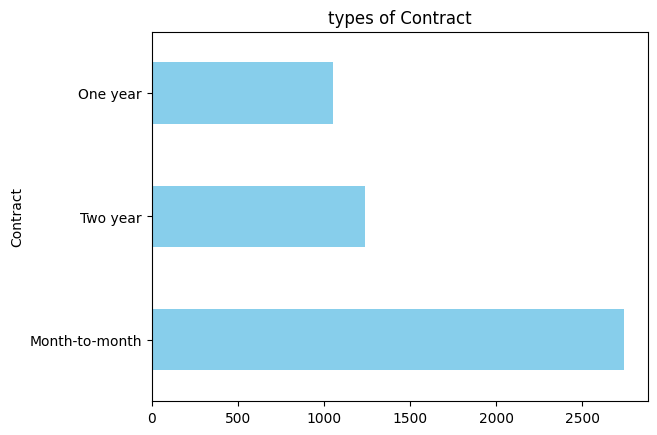

In [129]:
#visualize types of contracts

value_counts = df['Contract'].value_counts()

value_counts.plot(kind='barh', color='skyblue')

plt.title('types of Contract')
plt.show()


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, 0 to 2042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5034 non-null   object 
 1   SeniorCitizen     5034 non-null   bool   
 2   Partner           5034 non-null   bool   
 3   Dependents        5034 non-null   bool   
 4   tenure            5034 non-null   int64  
 5   PhoneService      5034 non-null   bool   
 6   MultipleLines     5034 non-null   bool   
 7   InternetService   5034 non-null   object 
 8   OnlineSecurity    5034 non-null   object 
 9   OnlineBackup      5034 non-null   object 
 10  DeviceProtection  5034 non-null   object 
 11  TechSupport       5034 non-null   object 
 12  StreamingTV       5034 non-null   object 
 13  StreamingMovies   5034 non-null   object 
 14  Contract          5034 non-null   object 
 15  PaperlessBilling  5034 non-null   object 
 16  PaymentMethod     5034 non-null   object 
 17  

## Check for outliers in integer and float datatypes (tenure, MonthlyCharges, and TotalCharges)

tenure


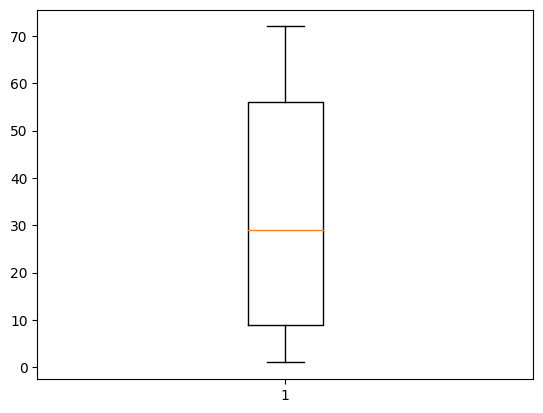

MonthlyCharges


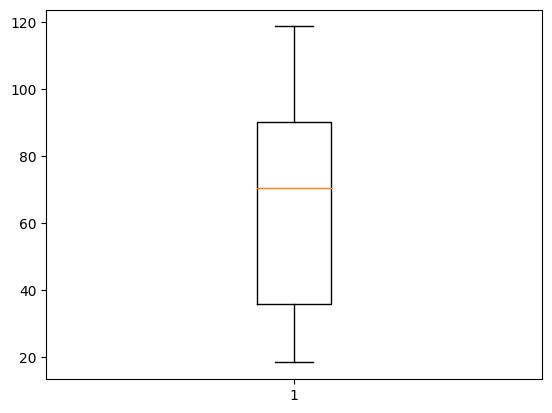

TotalCharges


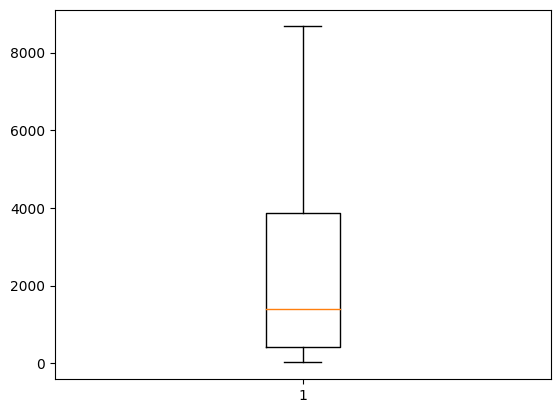

In [131]:
#check integer and float datatype columns for outliers using boxplots


for col in ['tenure','MonthlyCharges','TotalCharges']:
    print(col)
    plt.boxplot(df[col])
    plt.show()

There are no outliers in the numerical columns as shown above

# Exploratory Data Analysis 
-Univariate
-Bivariate
-Multivariate

## Frequency Distribution Analysis
This analysis is used to analyze continuous numerical data. 

In [132]:

df['MonthlyCharges'].describe()

count    5034.000000
mean       65.107251
std        30.068019
min        18.400000
25%        35.800000
50%        70.600000
75%        90.050000
max       118.650000
Name: MonthlyCharges, dtype: float64

Text(0.5, 1.0, 'Distribution of Monthly Charges')

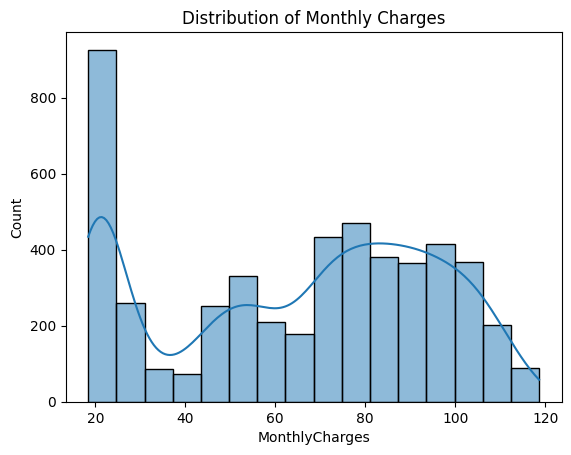

In [133]:
# Create the histogram plot of Monthly charges using seaborn

sns.histplot(data=df['MonthlyCharges'], kde=True)
plt.title('Distribution of Monthly Charges')

In [134]:
df['TotalCharges'].describe()

count    5034.000000
mean     2300.954758
std      2268.346401
min        18.800000
25%       417.662500
50%      1401.000000
75%      3860.600000
max      8670.100000
Name: TotalCharges, dtype: float64

Text(0.5, 1.0, 'Distribution of Total Charges')

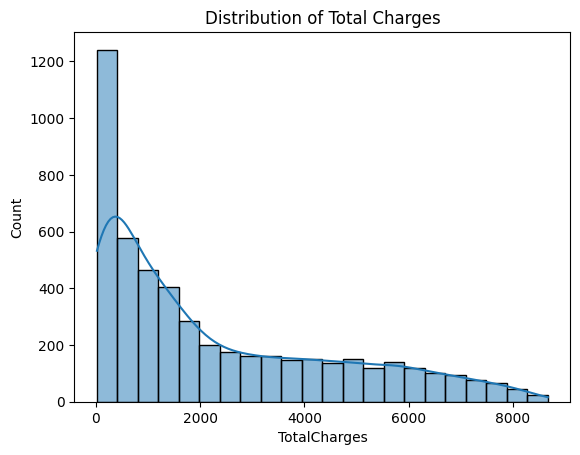

In [135]:
#sns.histplot(data=df['TotalCharges'], kde=True)

# Create the histogram plot using seaborn

sns.histplot(data=df['TotalCharges'], kde=True)
plt.title('Distribution of Total Charges')

In [136]:
np.histogram(df['TotalCharges'].dropna())

(array([1922,  888,  463,  364,  328,  306,  292,  224,  159,   88],
       dtype=int64),
 array([  18.8 ,  883.93, 1749.06, 2614.19, 3479.32, 4344.45, 5209.58,
        6074.71, 6939.84, 7804.97, 8670.1 ]))

In [137]:
df['SeniorCitizen'].value_counts()

SeniorCitizen
False    4215
True      819
Name: count, dtype: int64

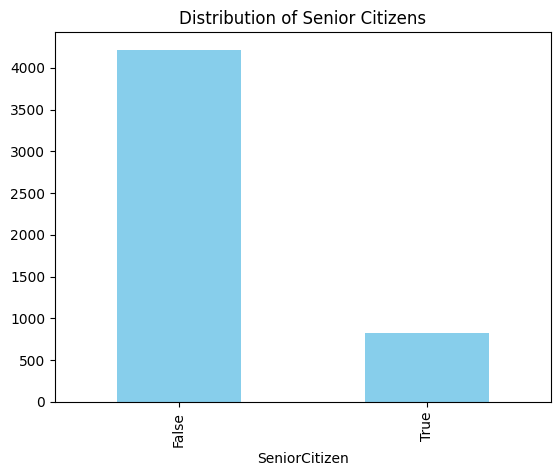

In [138]:
# visualize the 'SeniorCitizen column

value_counts = df['SeniorCitizen'].value_counts()

value_counts.plot(kind='bar', color='skyblue')

plt.title('Distribution of Senior Citizens')
plt.show()

In [139]:
df['gender'].value_counts()

gender
Male      2554
Female    2480
Name: count, dtype: int64

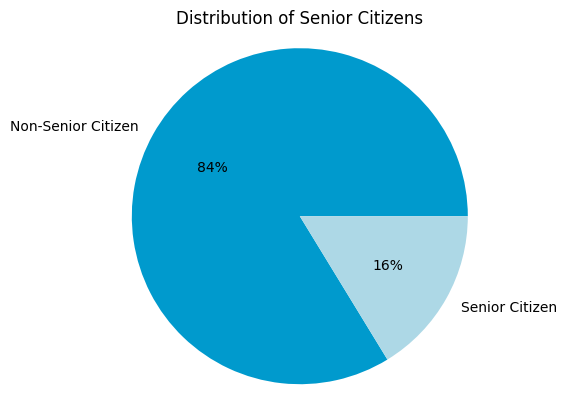

In [140]:
# Count and create pie chart of the 'SeniorCitizen' column

senior_citizen_counts = df['SeniorCitizen'].value_counts()
labels = ['Non-Senior Citizen', 'Senior Citizen']

counts = [senior_citizen_counts[0], senior_citizen_counts[1]]
colors = ['#009ACD', '#ADD8E6']

plt.pie(counts, labels=labels, colors=colors, autopct='%1.0f%%', shadow=False)
plt.axis('equal')

plt.title('Distribution of Senior Citizens')

plt.show()






In [141]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, 0 to 2042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5034 non-null   object 
 1   SeniorCitizen     5034 non-null   bool   
 2   Partner           5034 non-null   bool   
 3   Dependents        5034 non-null   bool   
 4   tenure            5034 non-null   int64  
 5   PhoneService      5034 non-null   bool   
 6   MultipleLines     5034 non-null   bool   
 7   InternetService   5034 non-null   object 
 8   OnlineSecurity    5034 non-null   object 
 9   OnlineBackup      5034 non-null   object 
 10  DeviceProtection  5034 non-null   object 
 11  TechSupport       5034 non-null   object 
 12  StreamingTV       5034 non-null   object 
 13  StreamingMovies   5034 non-null   object 
 14  Contract          5034 non-null   object 
 15  PaperlessBilling  5034 non-null   object 
 16  PaymentMethod     5034 non-null   object 
 17  

In [143]:
df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

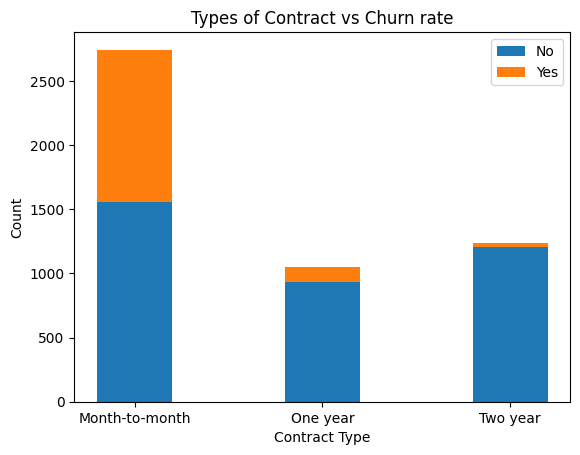

In [144]:
# Grouping and counting occurrences of each combination
grouped_df = df.groupby(['Contract', 'Churn']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
fig, ax = plt.subplots()

index = range(len(grouped_df))
width = 0.4

bars = []
bottom = [0] * len(grouped_df)

for churn_status in grouped_df.columns:
    bar = ax.bar(index, grouped_df[churn_status], width, bottom=bottom, label=churn_status)
    bars.append(bar)
    bottom = [bottom[i] + grouped_df[churn_status][i] for i in range(len(grouped_df))]

ax.set_xlabel('Contract Type')
ax.set_ylabel('Count')
ax.set_title('Types of Contract vs Churn rate')
ax.set_xticks(index)
ax.set_xticklabels(grouped_df.index)
ax.legend()

plt.show()

In [145]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

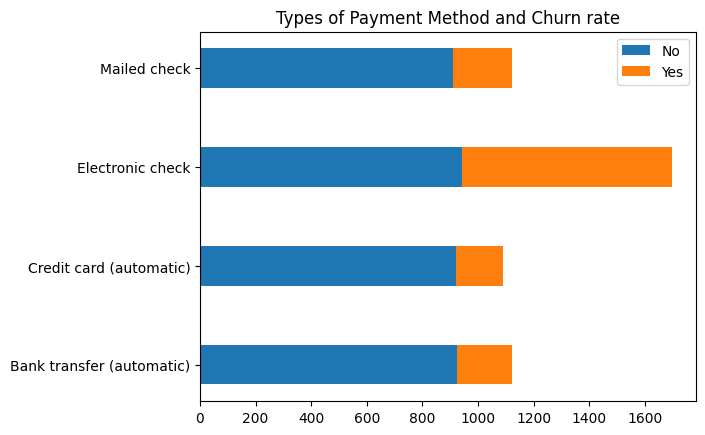

In [146]:
# Grouping and counting occurrences of each combination
grouped_df = df.groupby(['PaymentMethod', 'Churn']).size().unstack(fill_value=0)

# Plotting the horizontal stacked bar chart
fig, ax = plt.subplots()

index = range(len(grouped_df))
height = 0.4

bars = []
left = [0] * len(grouped_df)

for paymentmethod in grouped_df.columns:
    bar = ax.barh(index, grouped_df[paymentmethod], height, left=left, label=paymentmethod)
    bars.append(bar)
    left = [left[i] + grouped_df[paymentmethod][i] for i in range(len(grouped_df))]

#ax.set_ylabel('Payment Method')
#ax.set_xlabel('Count')
ax.set_title('Types of Payment Method and Churn rate')
ax.set_yticks(index)
ax.set_yticklabels(grouped_df.index)
ax.legend()

plt.show()


In [147]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [148]:
df['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [149]:

# Convert 'yes' and 'no' to binary values (1 for 'yes', 0 for 'no')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Calculate point-biserial correlation and p-values for each float column
for column in ['TotalCharges', 'MonthlyCharges', 'tenure']:
    correlation_coefficient, p_value = pointbiserialr(df['Churn'], df[column])
    print(f"Point-biserial correlation coefficient for {column}: {correlation_coefficient:.4f}")
    print(f"P-value for {column}: {p_value:.4f}")

Point-biserial correlation coefficient for TotalCharges: -0.1946
P-value for TotalCharges: 0.0000
Point-biserial correlation coefficient for MonthlyCharges: 0.2020
P-value for MonthlyCharges: 0.0000
Point-biserial correlation coefficient for tenure: -0.3526
P-value for tenure: 0.0000


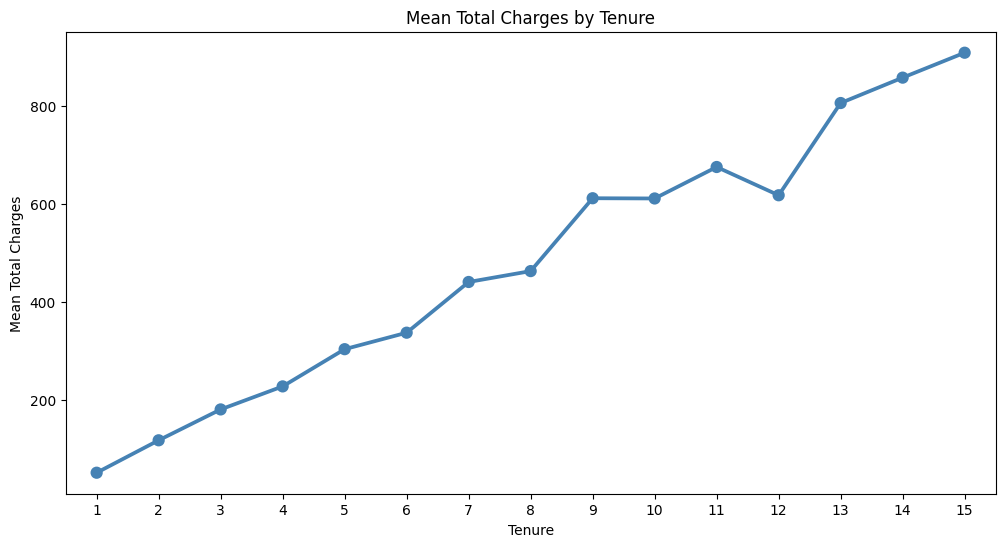

In [150]:
# Grouping by 'tenure' and calculating the mean 'TotalCharges'
df_grp_tenure = df.groupby('tenure')['TotalCharges'].mean().reset_index()

#Top 15 data points
df_grp_tenure_15 = df_grp_tenure.head(15)

# Create a point plot
plt.figure(figsize=(12, 6))
sns.pointplot(data=df_grp_tenure_15, x='tenure', y='TotalCharges', color='steelblue')

# Customize the plot
plt
plt.title('Mean Total Charges by Tenure')
plt.xlabel('Tenure')
plt.ylabel('Mean Total Charges')

# Show the plot
plt.show()

## Hypothesis testing
* H_o: Contract type does not influence customer Churn
* H_a: Contract type influences customer Churn

In [151]:

# Create a contingency table
contingency_table = pd.crosstab(df['Contract'], df['Churn'])

# Perform the chi-square test for independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Chi-Square Statistic: 877.9306786898616
P-value: 2.289683084478856e-191
Degrees of Freedom: 2
Expected Frequencies:
[[2015.7552642   728.2447358 ]
 [ 774.27334128  279.72665872]
 [ 907.97139452  328.02860548]]


From the chi-square test above we reject the null hypothesis since p-value is below our significance value of 0.05

## Train ML model
* Data Splitting
Since we already have our test set, split cleaned dataset into two parts: training set and evaluation set. 
* Feature Engineering
Prepare the features (input variables) and the target variables (Churn rate) for training. Ensure
that the features are in the right format(numerical or one-hot encoded for categorical features)
* Model Selection
Choose the appropriate ML algorithm for your problem. Classification problem (predicting categories)
* Model Training
Feed the training data into the chosen ML algorithm and train the model on the dataset. The model will learn the underlying patterns and relationships between the features and the target variable.
* Model Evaluation
Once the model is trained, use the test set to evaluate its performance. Common evaluation metrics for classification problems include accuracy, precision, recall, F1-score, etc.
* Hyperparameter Tuning
 Some ML algorithms have hyperparameters that need to be tuned to achieve optimal performance. Use techniques like grid search or random search to find the best combination of hyperparameters.
* Model Validation
After tuning the hyperparameters, retrain the model on the entire dataset (training + test) to maximize the use of data. Validate the model on a hold-out validation set to get a final estimate of its performance.
* Model Deployment
Once you are satisfied with the model's performance, you can deploy it to make predictions on new, unseen data


In [152]:
#Check the balance in the Churn column
#Percentage of customers who did not Churn

per_No = df['Churn'].value_counts()[0]/len(df['Churn'])*100

print(f'The percentage of customers who did not Churn is {per_No:.2f} %')

The percentage of customers who did not Churn is 73.46 %


In [153]:
#Check the balance in the Churn column
#Percentage of customers who Churned

per_Yes=df['Churn'].value_counts()[1]/len(df['Churn'])*100
print(f'The percentage of customers who did Churn is {per_Yes:.2f} %')

The percentage of customers who did Churn is 26.54 %


In [154]:
# Separate features (X) and target variable (y)
X = df.drop(columns=['Churn'])
y = df['Churn']


In [155]:
# check if separation is successful

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5034 entries, 0 to 2042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5034 non-null   object 
 1   SeniorCitizen     5034 non-null   bool   
 2   Partner           5034 non-null   bool   
 3   Dependents        5034 non-null   bool   
 4   tenure            5034 non-null   int64  
 5   PhoneService      5034 non-null   bool   
 6   MultipleLines     5034 non-null   bool   
 7   InternetService   5034 non-null   object 
 8   OnlineSecurity    5034 non-null   object 
 9   OnlineBackup      5034 non-null   object 
 10  DeviceProtection  5034 non-null   object 
 11  TechSupport       5034 non-null   object 
 12  StreamingTV       5034 non-null   object 
 13  StreamingMovies   5034 non-null   object 
 14  Contract          5034 non-null   object 
 15  PaperlessBilling  5034 non-null   object 
 16  PaymentMethod     5034 non-null   object 
 17  

In [156]:
y.info()

<class 'pandas.core.series.Series'>
Index: 5034 entries, 0 to 2042
Series name: Churn
Non-Null Count  Dtype
--------------  -----
5034 non-null   int64
dtypes: int64(1)
memory usage: 78.7 KB


In [157]:
# Use RandomOverSampler to balance the data

ros = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Original data = X and y
# The resampled data = X_resampled and y_resampled.
# We can now use these resampled datasets and orginal data for modeling and compare if the balancing had an effect


In [158]:
# check shapes of df (original train dataset), X and y

print(df.shape, X.shape, y.shape)

(5034, 20) (5034, 19) (5034,)


In [159]:
# check shapes of resampled data, X_resampled and y_resampled

print(X_resampled.shape, y_resampled.shape)

# rows in the resampled data has increased to balance

(5547, 19) (5547,)


In [160]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5547 entries, 0 to 5546
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5547 non-null   object 
 1   SeniorCitizen     5547 non-null   bool   
 2   Partner           5547 non-null   bool   
 3   Dependents        5547 non-null   bool   
 4   tenure            5547 non-null   int64  
 5   PhoneService      5547 non-null   bool   
 6   MultipleLines     5547 non-null   bool   
 7   InternetService   5547 non-null   object 
 8   OnlineSecurity    5547 non-null   object 
 9   OnlineBackup      5547 non-null   object 
 10  DeviceProtection  5547 non-null   object 
 11  TechSupport       5547 non-null   object 
 12  StreamingTV       5547 non-null   object 
 13  StreamingMovies   5547 non-null   object 
 14  Contract          5547 non-null   object 
 15  PaperlessBilling  5547 non-null   object 
 16  PaymentMethod     5547 non-null   object 


## Dataset Splitting

In [161]:
# pick out boolean columns and save it as bool_cols

bool_cols = list(X_resampled.select_dtypes('bool'))
bool_cols

['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines']

In [162]:
# convert bool_cols to integers

for col in bool_cols:
    X_resampled[col]=X_resampled[col].astype(int)

In [163]:
num_cols = list(X_resampled.select_dtypes('number'))
cat_cols = list(X_resampled.select_dtypes(exclude='number'))
print(f"The '{len(num_cols)}' numeric columns are: {num_cols}")
print(f"The '{len(cat_cols)}' categorical columns are: {cat_cols}")

The '8' numeric columns are: ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'MonthlyCharges', 'TotalCharges']
The '11' categorical columns are: ['gender', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


<Figure size 1600x1200 with 0 Axes>

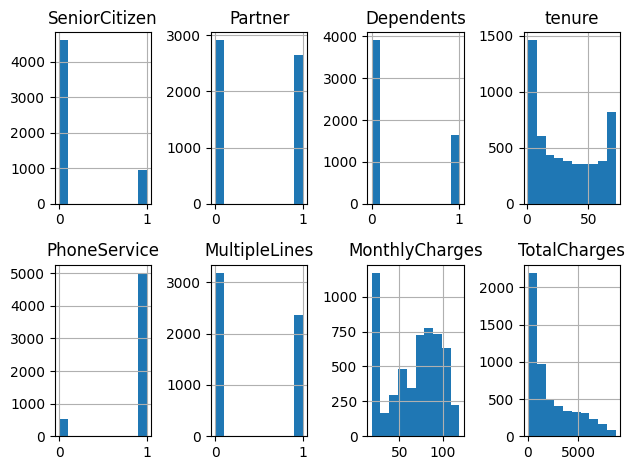

In [225]:
# check the distribution of various columns

plt.figure(figsize=(16, 12))  # Adjust the figure size as needed
X_resampled.hist(layout=(2, 4)) 

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

<Axes: >

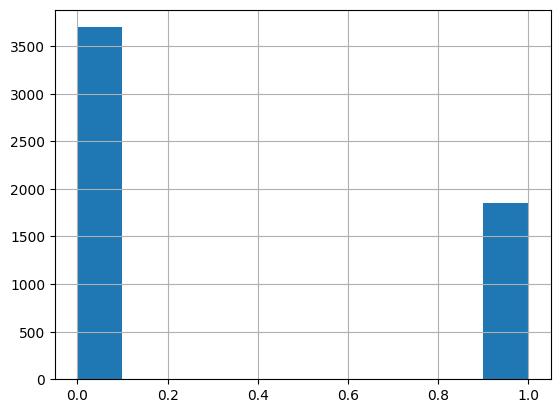

In [165]:
y_resampled.hist()

In [166]:
# Use train_test_split with a random_state, and add stratify for Classification
stratify = y_resampled if y.dtype == "O" else None
X_train, X_eval, y_train, y_eval = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 1, stratify = stratify )  

In [167]:
num_imputer = SimpleImputer(strategy="median").fit(X_train[num_cols])
cat_imputer = SimpleImputer(strategy="most_frequent").fit(X_train[cat_cols])

In [168]:
num_imputer.transform(X_train[num_cols]) 

array([[0.00000e+00, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        8.00500e+01, 8.00500e+01],
       [0.00000e+00, 0.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        2.01500e+01, 6.82150e+02],
       [0.00000e+00, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        1.99500e+01, 1.30325e+03],
       ...,
       [0.00000e+00, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        2.03500e+01, 2.03500e+01],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        5.44000e+01, 1.14100e+02],
       [0.00000e+00, 1.00000e+00, 1.00000e+00, ..., 1.00000e+00,
        9.98000e+01, 4.87245e+03]])

In [176]:
X_train_num_imputed = pd.DataFrame(num_imputer.transform(X_train[num_cols]), columns=num_cols)
X_eval_num_imputed = pd.DataFrame(num_imputer.transform(X_eval[num_cols]), columns=num_cols)

X_train_cat_imputed = pd.DataFrame(cat_imputer.transform(X_train[cat_cols]), columns=cat_cols)
X_eval_cat_imputed = pd.DataFrame(cat_imputer.transform(X_eval[cat_cols]), columns=cat_cols)

X_train_imputed = pd.concat([X_train_num_imputed, X_train_cat_imputed], axis=1)
X_eval_imputed = pd.concat([X_eval_num_imputed, X_eval_cat_imputed], axis=1)

In [171]:
X_train_cat_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            4437 non-null   object
 1   InternetService   4437 non-null   object
 2   OnlineSecurity    4437 non-null   object
 3   OnlineBackup      4437 non-null   object
 4   DeviceProtection  4437 non-null   object
 5   TechSupport       4437 non-null   object
 6   StreamingTV       4437 non-null   object
 7   StreamingMovies   4437 non-null   object
 8   Contract          4437 non-null   object
 9   PaperlessBilling  4437 non-null   object
 10  PaymentMethod     4437 non-null   object
dtypes: object(11)
memory usage: 381.4+ KB


In [172]:
X_eval_cat_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            1110 non-null   object
 1   InternetService   1110 non-null   object
 2   OnlineSecurity    1110 non-null   object
 3   OnlineBackup      1110 non-null   object
 4   DeviceProtection  1110 non-null   object
 5   TechSupport       1110 non-null   object
 6   StreamingTV       1110 non-null   object
 7   StreamingMovies   1110 non-null   object
 8   Contract          1110 non-null   object
 9   PaperlessBilling  1110 non-null   object
 10  PaymentMethod     1110 non-null   object
dtypes: object(11)
memory usage: 95.5+ KB


## Features Encoding

In [196]:
#encoder = OneHotEncoder(sparse=False, drop="first").fit(X_train_cat_imputed)
#encoder = OneHotEncoder(sparse=False, drop="first").fit(X_eval_cat_imputed)

#cat_encoded_cols = encoder.get_feature_names_out().tolist()

# One-hot encode categorical columns


In [179]:
# convert X_train and X_eval to string/object datatype to enable encoding
# encoding was encountering errors because of different dtypes

X_train_cat_imputed = X_train_cat_imputed.astype(str)
X_eval_cat_imputed = X_eval_cat_imputed.astype(str)
encoder = OneHotEncoder(sparse=False, drop="first").fit(X_train_cat_imputed)
encoder

In [184]:
# convert X_train and X_eval to string/object datatype to enable encoding

X_eval_cat_imputed = X_eval_cat_imputed.astype(str)
encoder = OneHotEncoder(sparse=False, drop="first").fit(X_eval_cat_imputed)
cat_encoded_cols = encoder.get_feature_names_out().tolist()

In [186]:
# convert to dataframe and transform imputed X_train and X_eval 

X_train_cat_encoded = pd.DataFrame(encoder.transform(X_train_cat_imputed), columns=cat_encoded_cols)
X_eval_cat_encoded = pd.DataFrame(encoder.transform(X_eval_cat_imputed), columns=cat_encoded_cols)

In [187]:
# preview X_train

X_train_cat_encoded.head()

,gender_Male,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No Internet,OnlineSecurity_True,OnlineSecurity_Yes,OnlineBackup_No Internet,OnlineBackup_Yes,DeviceProtection_No internet service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [188]:
# preview X_eval

X_eval_cat_encoded.head()

,gender_Male,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No Internet,OnlineSecurity_True,OnlineSecurity_Yes,OnlineBackup_No Internet,OnlineBackup_Yes,DeviceProtection_No internet service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


## Features Scaling

In [189]:
# Scale train and evaluation datasets
# preview scaled X_train

scaler = StandardScaler().fit(X_train_num_imputed)
X_train_num_scaled = pd.DataFrame(scaler.transform(X_train_num_imputed), columns=num_cols)
X_eval_num_scaled = pd.DataFrame(scaler.transform(X_eval_num_imputed), columns=num_cols)
X_train_num_scaled.head()

In [192]:
# combine scaled and encoded datasets into X_train and X_eval ready dataset
# preview dataset

X_train_ready = pd.concat([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_eval_ready = pd.concat([X_eval_num_scaled, X_eval_cat_encoded], axis=1)

X_train_ready.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,MonthlyCharges,TotalCharges,gender_Male,InternetService_Fiber optic,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.453188,1.042131,1.525151,-1.243883,0.3225,-0.871389,0.468050,-0.961539,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.453188,-0.959572,1.525151,0.060042,0.3225,-0.871389,-1.534494,-0.695247,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,-0.453188,1.042131,1.525151,1.486211,0.3225,-0.871389,-1.541181,-0.420552,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,2.206592,-0.959572,-0.655673,0.019295,0.3225,1.147594,1.006296,0.338387,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2.206592,1.042131,-0.655673,1.445463,0.3225,1.147594,1.315537,2.114705,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [195]:
# preview X_eval dataset

X_eval_ready.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,MonthlyCharges,TotalCharges,gender_Male,InternetService_Fiber optic,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.453188,1.042131,1.525151,1.567706,0.3225,1.147594,0.665295,1.626504,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1,-0.453188,1.042131,1.525151,1.649201,0.3225,1.147594,1.484366,2.567260,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-0.453188,-0.959572,-0.655673,0.060042,0.3225,1.147594,0.822423,0.325273,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2.206592,1.042131,-0.655673,0.100790,0.3225,1.147594,0.317608,0.075744,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.453188,1.042131,-0.655673,-0.347434,0.3225,1.147594,0.254088,-0.270400,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [219]:
# Create a function for machine learning model
# the model indicates the name of model, trains that model and prints out an accuracy score, 
# classification report, and confusion matrix.

def model_bulding(model,X_train_ready,X_eval_ready,y_train,y_eval):
    print(f'Name of the model: {model}')
    model.fit(X_train_ready,y_train)
    y_pred=model.predict(X_eval_ready)
    score=accuracy_score(y_eval,y_pred)
    print(f'\nThe Accuracy_score is {score*100:.2f}')
    print(f'\n{classification_report(y_eval,y_pred)}')
    print(f'\n{confusion_matrix(y_eval,y_pred)}')
    print('__'*20)

Selected models
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* Ada Boost Classifier
* Gradient Boosting Classifier

In [220]:
# Create all model into the dictionary format
models={
    'logistic':LogisticRegression(),
    'decisiontree':DecisionTreeClassifier(),
    'random':RandomForestClassifier(),
    'adaboost':AdaBoostClassifier(),
    'gb_model':GradientBoostingClassifier()
    
}

In [221]:
# Iterate through each model and visualize the classification and confusion reports

for i in range(len(models)):
    model=list(models.values())[i]
    name=list(models.keys())[i]
    model_bulding(model,X_train_ready,X_eval_ready,y_train,y_eval)

Name of the model: LogisticRegression()

The Accuracy_score is 75.14

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       748
           1       0.62      0.63      0.62       362

    accuracy                           0.75      1110
   macro avg       0.72      0.72      0.72      1110
weighted avg       0.75      0.75      0.75      1110


[[605 143]
 [133 229]]
________________________________________
Name of the model: DecisionTreeClassifier()

The Accuracy_score is 77.57

              precision    recall  f1-score   support

           0       0.86      0.79      0.83       748
           1       0.63      0.74      0.68       362

    accuracy                           0.78      1110
   macro avg       0.75      0.77      0.75      1110
weighted avg       0.79      0.78      0.78      1110


[[594 154]
 [ 95 267]]
________________________________________
Name of the model: RandomForestClassifier()

The Accuracy_score is 81.62


## Cross-Validation

Instead of a single train-validation-test split, we do a cross-validation, which involves repeatedly splitting the training data into different subsets (folds). This way, we can perform multiple rounds of training and evaluation to get more reliable performance estimates.

In [232]:
# Create a function for cross-validation which takes in model, train dataset, and target variable
# Train the model five times using a cv of 5
# Print out the name of the model
# Print out the mean accuracy for comparison

def model_cv_scores(model,X_train_ready,y_train):
    print(f'Name of the model: {model}')
    cv_scores = cross_val_score(model, X_train_ready, y_train, cv=5, scoring='accuracy')
    print(f"\n Cross-Validation Scores are {cv_scores}")
    print(f"\n Mean Accuracy is {cv_scores.mean()*100:.2f}")
    print('__'*20)


    

In [233]:
# Create all model into the dictionary format

models={
    'logistic':LogisticRegression(),
    'decisiontree':DecisionTreeClassifier(),
    'random':RandomForestClassifier(),
    'adaboost':AdaBoostClassifier(),
    'gb_model':GradientBoostingClassifier()
}

In [234]:
# Iterate through each model and print out the cross validation scores and mean accuracy 

for i in range(len(models)):
    model=list(models.values())[i]
    name=list(models.keys())[i]
    model_cv_scores(model,X_train_ready,y_train)

Name of the model: LogisticRegression()

 Cross-Validation Scores are [0.78378378 0.7759009  0.79368658 0.789177   0.77903044]

 Mean Accuracy is 78.43
________________________________________
Name of the model: DecisionTreeClassifier()

 Cross-Validation Scores are [0.75112613 0.76126126 0.7373168  0.7632469  0.77564825]

 Mean Accuracy is 75.77
________________________________________
Name of the model: RandomForestClassifier()

 Cross-Validation Scores are [0.81869369 0.81756757 0.83201804 0.83427283 0.83427283]

 Mean Accuracy is 82.74
________________________________________
Name of the model: AdaBoostClassifier()

 Cross-Validation Scores are [0.7759009  0.78040541 0.80157835 0.78466742 0.789177  ]

 Mean Accuracy is 78.63
________________________________________
Name of the model: GradientBoostingClassifier()

 Cross-Validation Scores are [0.79391892 0.78265766 0.80496054 0.79819617 0.79143179]

 Mean Accuracy is 79.42
________________________________________


From above, Random Forest Classifier had the highest mean Accuracy of 82.74 percent, this was an improvement from the earlier 81.62 percent when the model was trained only once. Decision Tree classifier had the lowest of 75.77 percent mean accuracy. 



## Fine-Tuning Models
Hyperparameter Tuning of the Random forest classifier. 


In [249]:
# get parameter of random forest classifier

print(RandomForestClassifier().get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [239]:
# Grid Search
# Using Scikit-Learn's GridSearchCV 
# create a dictionary of multiple combinations to test

param_grid = {
    'n_estimators' : [3, 10, 30],
    'max_features' : [2, 4, 6, 8],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4]
}

model = RandomForestClassifier()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_ready,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [2, 4, 6, 8],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [3, 10, 30]},
             scoring='accuracy')

In [240]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [242]:
best_params

{'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 30}

In [244]:
best_model

RandomForestClassifier(max_features=4, n_estimators=30)

In [241]:

y_pred = best_model.predict(X_eval_ready)

accuracy = accuracy_score(y_eval,y_pred)
print("Best Model Accuracy:", accuracy)



Best Model Accuracy: 0.8153153153153153


In [248]:
print(RandomForestClassifier().get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [250]:
random_b_model=RandomForestClassifier(
    max_features=4,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=30,
    random_state=1
)

random_b_model.fit(X_train_ready,y_train)

RandomForestClassifier(max_features=4, n_estimators=30, random_state=1)

In [251]:
y_pred_b_model= random_b_model.predict(X_eval_ready)

In [252]:
scores = cross_val_score(random_b_model, X_train_ready, y_train, cv=5, scoring='accuracy')

mean_accuracy = scores.mean()

print("Mean Accuracy:", mean_accuracy)

Mean Accuracy: 0.8257866378215871


Models comparison